# 21.4 — Scenario & Sensitivity Analysis (Monte Carlo Decision Experiments)

**Colab-safe notebook** for comparing reliability improvement levers using Monte Carlo.

## What this notebook does
1. Uses Weibull(β, η) + repair time (TTR) uncertainty to simulate a repairable fleet.
2. Runs multiple **scenarios** (baseline vs improvements).
3. Produces decision KPIs per scenario:
   - Mean availability + tail bands (P5/P50/P95)
   - Mean downtime + tail (P90/P95)
   - **Risk-of-breach** at a downtime threshold (e.g., 120 h/year)
   - **Service level** at an availability target (e.g., 99.90%)
4. Produces a **sensitivity (tornado-like)** view by varying key levers:
   - η multiplier (MTBF improvement)
   - Repair time mean multiplier (maintenance/logistics improvement)

Figures saved to `figures/` (300 DPI). Scenario tables exported to `outputs/`.


## 0) Install dependencies (Colab)

In [1]:
# If running in Google Colab, uncomment and run once:
!pip install "numpy<2.0"
!pip -q install reliability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.2/257.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 90.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.2 which is incompatible.


## 1) Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2) Output folders

In [2]:
FIG_DIR = "figures"
OUT_DIR = "outputs"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

def savefig(name: str):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

## 3) Baseline inputs (edit to match your plant)

Default values reflect the 21.3 example output:
- β ≈ 1.196
- η ≈ 7977 hours


In [3]:
# === Baseline failure model (Weibull) ===
BETA_BASE = 1.196
ETA_BASE_H = 7977.0  # hours

# === Baseline repair time (TTR) ===
TTR_DIST = "lognormal"  # "lognormal", "normal", "fixed"
TTR_MEAN_H = 8.0
TTR_STD_H  = 4.0
TTR_FIXED_H = 8.0

# === Fleet / mission ===
N_UNITS   = 10
T_HORIZON = 8760.0  # hours (1 year)
N_SIM     = 10000
SEED      = 777

# === Decision thresholds (edit to your governance requirements) ===
DOWNTIME_THRESHOLD_H = 120.0     # hours per year (fleet)
AVAILABILITY_TARGET  = 0.9990    # 99.90%

## 4) Sampling utilities (Weibull + Repair time)

In [4]:
def sample_ttr(rng, size=1, dist="lognormal", mean_h=8.0, std_h=4.0, fixed_h=8.0):
    if dist == "fixed":
        return np.full(size, fixed_h, dtype=float)

    if dist == "normal":
        x = rng.normal(mean_h, std_h, size=size)
        return np.maximum(x, 0.01)

    if dist == "lognormal":
        mean = max(mean_h, 0.01)
        std  = max(std_h, 0.01)
        var = std**2
        sigma2 = np.log(1 + var/(mean**2))
        sigma = np.sqrt(sigma2)
        mu = np.log(mean) - 0.5*sigma2
        return rng.lognormal(mean=mu, sigma=sigma, size=size)

    raise ValueError("Unknown TTR_DIST")

def simulate_one_unit_repairable(rng, beta, eta_h, horizon_h, ttr_dist, ttr_mean_h, ttr_std_h, ttr_fixed_h):
    t = 0.0
    downtime = 0.0
    failures = 0
    while t < horizon_h:
        ttf = eta_h * rng.weibull(beta)
        t = min(t + ttf, horizon_h)
        if t >= horizon_h:
            break
        failures += 1
        ttr = float(sample_ttr(rng, 1, ttr_dist, ttr_mean_h, ttr_std_h, ttr_fixed_h)[0])
        down_end = min(t + ttr, horizon_h)
        downtime += max(0.0, down_end - t)
        t = down_end
    return downtime, failures

def run_fleet_sim(beta, eta_h, n_units, horizon_h, n_sim, seed,
                  ttr_dist, ttr_mean_h, ttr_std_h, ttr_fixed_h):
    rng = np.random.default_rng(seed)
    fleet_downtime = np.empty(n_sim, dtype=float)
    fleet_failures = np.empty(n_sim, dtype=int)
    fleet_avail    = np.empty(n_sim, dtype=float)

    for i in range(n_sim):
        total_down = 0.0
        total_fail = 0
        for _ in range(n_units):
            down, fails = simulate_one_unit_repairable(
                rng, beta, eta_h, horizon_h, ttr_dist, ttr_mean_h, ttr_std_h, ttr_fixed_h
            )
            total_down += down
            total_fail += fails

        fleet_downtime[i] = total_down
        fleet_failures[i] = total_fail
        fleet_avail[i] = (n_units * horizon_h - total_down) / (n_units * horizon_h)

    return fleet_downtime, fleet_avail, fleet_failures

def stats(x):
    x = np.asarray(x)
    return {
        "mean": float(np.mean(x)),
        "p5": float(np.percentile(x, 5)),
        "p50": float(np.percentile(x, 50)),
        "p90": float(np.percentile(x, 90)),
        "p95": float(np.percentile(x, 95)),
        "p99": float(np.percentile(x, 99)),
    }

## 5) Define scenarios

Improvements are expressed as multipliers:
- η multiplier > 1: fewer failures (MTBF improvement)
- TTR mean multiplier < 1: faster repairs


In [5]:
scenarios = [
    {"Scenario": "Baseline",                "eta_mult": 1.00, "beta_mult": 1.00, "ttr_mean_mult": 1.00, "ttr_std_mult": 1.00},
    {"Scenario": "MTBF +15% (η×1.15)",      "eta_mult": 1.15, "beta_mult": 1.00, "ttr_mean_mult": 1.00, "ttr_std_mult": 1.00},
    {"Scenario": "MTBF +30% (η×1.30)",      "eta_mult": 1.30, "beta_mult": 1.00, "ttr_mean_mult": 1.00, "ttr_std_mult": 1.00},
    {"Scenario": "Repair -25% (TTR×0.75)",  "eta_mult": 1.00, "beta_mult": 1.00, "ttr_mean_mult": 0.75, "ttr_std_mult": 0.75},
    {"Scenario": "Repair -40% (TTR×0.60)",  "eta_mult": 1.00, "beta_mult": 1.00, "ttr_mean_mult": 0.60, "ttr_std_mult": 0.60},
    {"Scenario": "Combined (η×1.15, TTR×0.75)", "eta_mult": 1.15, "beta_mult": 1.00, "ttr_mean_mult": 0.75, "ttr_std_mult": 0.75},
]

## 6) Run scenarios and compute decision KPIs

In [6]:
rows = []

for i, sc in enumerate(scenarios):
    beta = BETA_BASE * sc["beta_mult"]
    eta  = ETA_BASE_H * sc["eta_mult"]
    ttr_mean = TTR_MEAN_H * sc["ttr_mean_mult"]
    ttr_std  = TTR_STD_H  * sc["ttr_std_mult"]

    seed = SEED + i * 1000

    dow, av, fc = run_fleet_sim(
        beta=beta, eta_h=eta,
        n_units=N_UNITS, horizon_h=T_HORIZON,
        n_sim=N_SIM, seed=seed,
        ttr_dist=TTR_DIST, ttr_mean_h=ttr_mean, ttr_std_h=ttr_std, ttr_fixed_h=TTR_FIXED_H
    )

    av_s  = stats(av)
    dow_s = stats(dow)
    fc_s  = stats(fc)

    risk_breach = float(np.mean(dow >= DOWNTIME_THRESHOLD_H))
    service_lvl = float(np.mean(av >= AVAILABILITY_TARGET))

    rows.append({
        "Scenario": sc["Scenario"],
        "beta": beta,
        "eta_hours": eta,
        "ttr_dist": TTR_DIST,
        "ttr_mean_h": ttr_mean,
        "ttr_std_h": ttr_std,
        "Availability_mean": av_s["mean"],
        "Availability_P5": av_s["p5"],
        "Availability_P50": av_s["p50"],
        "Availability_P95": av_s["p95"],
        "Downtime_mean_h": dow_s["mean"],
        "Downtime_P90_h": dow_s["p90"],
        "Downtime_P95_h": dow_s["p95"],
        "Failures_mean": fc_s["mean"],
        "Failures_P95": fc_s["p95"],
        "Risk_Breach_Downtime>=Threshold": risk_breach,
        "ServiceLevel_Availability>=Target": service_lvl
    })

scenario_df = pd.DataFrame(rows)
scenario_path = os.path.join(OUT_DIR, "MC_21_4_scenario_kpis.csv")
scenario_df.to_csv(scenario_path, index=False)
print("Saved scenario KPI table:", scenario_path)

scenario_df

Saved scenario KPI table: outputs/MC_21_4_scenario_kpis.csv


,Scenario,beta,eta_hours,ttr_dist,ttr_mean_h,ttr_std_h,Availability_mean,Availability_P5,Availability_P50,Availability_P95,Downtime_mean_h,Downtime_P90_h,Downtime_P95_h,Failures_mean,Failures_P95,Risk_Breach_Downtime>=Threshold,ServiceLevel_Availability>=Target
0,Baseline,1.196,7977.00,lognormal,8.0,4.0,0.999062,0.998512,0.999087,0.999540,82.166223,118.187897,130.336142,10.2585,15.0,0.0915,0.6074
1,MTBF +15% (η×1.15),1.196,9173.55,lognormal,8.0,4.0,0.999194,0.998691,0.999215,0.999621,70.566753,103.762016,114.658947,8.8326,14.0,0.0340,0.7651
2,MTBF +30% (η×1.30),1.196,10370.10,lognormal,8.0,4.0,0.999304,0.998833,0.999326,0.999706,61.004729,91.804688,102.259420,7.6395,12.0,0.0150,0.8685
3,Repair -25% (TTR×0.75),1.196,7977.00,lognormal,6.0,3.0,0.999297,0.998897,0.999311,0.999651,61.608761,87.745654,96.624407,10.2668,15.0,0.0044,0.8990
4,Repair -40% (TTR×0.60),1.196,7977.00,lognormal,4.8,2.4,0.999437,0.999118,0.999450,0.999714,49.292276,70.598331,77.297983,10.2886,15.0,0.0001,0.9823
5,"Combined (η×1.15, TTR×0.75)",1.196,9173.55,lognormal,6.0,3.0,0.999398,0.999024,0.999415,0.999727,52.729794,77.917785,85.511791,8.7948,14.0,0.0012,0.9574


## 7) Plot: Scenario comparison — Availability

Saved: figures/MC_21_4_scenario_availability.png


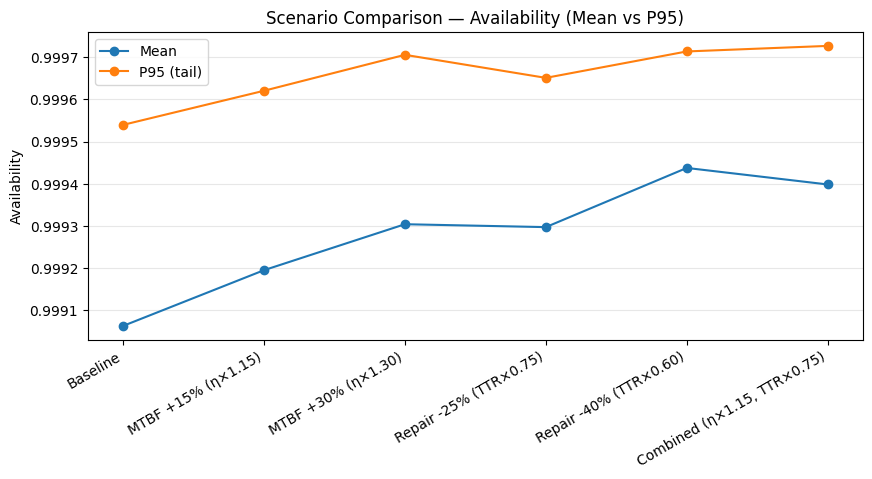

In [7]:
x = np.arange(len(scenario_df))
labels = scenario_df["Scenario"].tolist()

plt.figure(figsize=(10,4))
plt.plot(x, scenario_df["Availability_mean"], marker="o", label="Mean")
plt.plot(x, scenario_df["Availability_P95"], marker="o", label="P95 (tail)")
plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Availability")
plt.title("Scenario Comparison — Availability (Mean vs P95)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
savefig("MC_21_4_scenario_availability.png")
plt.show()

## 8) Plot: Scenario comparison — Downtime (tail risk)

Saved: figures/MC_21_4_scenario_downtime.png


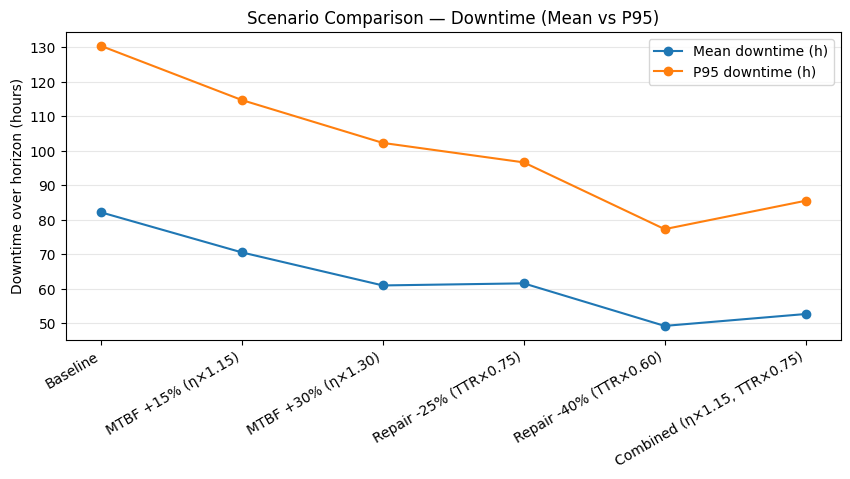

In [8]:
plt.figure(figsize=(10,4))
plt.plot(x, scenario_df["Downtime_mean_h"], marker="o", label="Mean downtime (h)")
plt.plot(x, scenario_df["Downtime_P95_h"], marker="o", label="P95 downtime (h)")
plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Downtime over horizon (hours)")
plt.title("Scenario Comparison — Downtime (Mean vs P95)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
savefig("MC_21_4_scenario_downtime.png")
plt.show()

## 9) Plot: Scenario comparison — Decision KPIs

Saved: figures/MC_21_4_scenario_decision_kpis.png


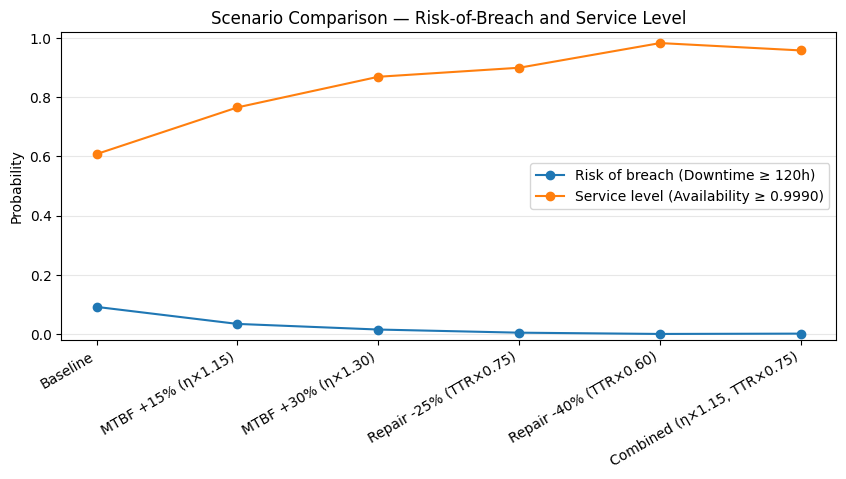

In [9]:
plt.figure(figsize=(10,4))
plt.plot(x, scenario_df["Risk_Breach_Downtime>=Threshold"], marker="o",
         label=f"Risk of breach (Downtime ≥ {DOWNTIME_THRESHOLD_H:.0f}h)")
plt.plot(x, scenario_df["ServiceLevel_Availability>=Target"], marker="o",
         label=f"Service level (Availability ≥ {AVAILABILITY_TARGET:.4f})")
plt.xticks(x, labels, rotation=30, ha="right")
plt.ylim(-0.02, 1.02)
plt.ylabel("Probability")
plt.title("Scenario Comparison — Risk-of-Breach and Service Level")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
savefig("MC_21_4_scenario_decision_kpis.png")
plt.show()

## 10) Sensitivity analysis (one lever at a time)

In [10]:
eta_mult_grid = [0.85, 0.90, 1.00, 1.10, 1.20, 1.30]
ttr_mult_grid = [1.30, 1.15, 1.00, 0.85, 0.75, 0.60]

def evaluate_one(beta, eta_h, ttr_mean_h, ttr_std_h, seed):
    dow, av, _ = run_fleet_sim(beta, eta_h, N_UNITS, T_HORIZON, N_SIM, seed, TTR_DIST, ttr_mean_h, ttr_std_h, TTR_FIXED_H)
    av_s = stats(av); dow_s = stats(dow)
    return {
        "Availability_mean": av_s["mean"],
        "Downtime_P95_h": dow_s["p95"],
        "Risk_Breach": float(np.mean(dow >= DOWNTIME_THRESHOLD_H)),
    }

base_eval = evaluate_one(BETA_BASE, ETA_BASE_H, TTR_MEAN_H, TTR_STD_H, SEED)

eta_sens = []
for k, m in enumerate(eta_mult_grid):
    ev = evaluate_one(BETA_BASE, ETA_BASE_H * m, TTR_MEAN_H, TTR_STD_H, SEED + 5000 + k*111)
    eta_sens.append({"Lever": f"η×{m:.2f}", **ev})

ttr_sens = []
for k, m in enumerate(ttr_mult_grid):
    ev = evaluate_one(BETA_BASE, ETA_BASE_H, TTR_MEAN_H * m, TTR_STD_H * m, SEED + 8000 + k*111)
    ttr_sens.append({"Lever": f"TTR×{m:.2f}", **ev})

eta_sens_df = pd.DataFrame(eta_sens)
ttr_sens_df = pd.DataFrame(ttr_sens)

eta_sens_df.to_csv(os.path.join(OUT_DIR, "MC_21_4_sensitivity_eta.csv"), index=False)
ttr_sens_df.to_csv(os.path.join(OUT_DIR, "MC_21_4_sensitivity_ttr.csv"), index=False)

base_eval, eta_sens_df, ttr_sens_df

({'Availability_mean': 0.999062029417369,
  'Downtime_P95_h': 130.33614188584994,
  'Risk_Breach': 0.0915},
     Lever  Availability_mean  Downtime_P95_h  Risk_Breach
 0  η×0.85           0.998879      150.760155       0.2204
 1  η×0.90           0.998951      141.084999       0.1590
 2  η×1.00           0.999063      128.674320       0.0858
 3  η×1.10           0.999157      119.994419       0.0500
 4  η×1.20           0.999234      110.658972       0.0250
 5  η×1.30           0.999300      102.628171       0.0141,
       Lever  Availability_mean  Downtime_P95_h  Risk_Breach
 0  TTR×1.30           0.998790      167.559964       0.3236
 1  TTR×1.15           0.998925      149.645587       0.2014
 2  TTR×1.00           0.999063      129.245172       0.0859
 3  TTR×0.85           0.999201      110.889138       0.0263
 4  TTR×0.75           0.999295       98.300059       0.0060
 5  TTR×0.60           0.999439       77.851823       0.0002)

### 10.1 Plot sensitivity — Mean availability

Saved: figures/MC_21_4_sensitivity_availability_mean.png


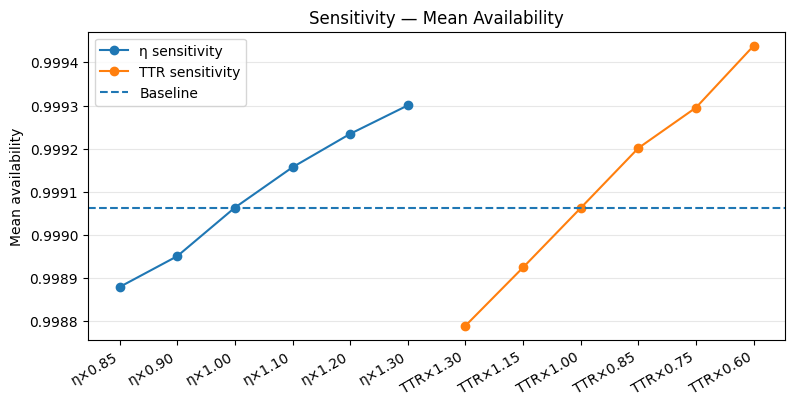

In [11]:
plt.figure(figsize=(9,4))
plt.plot(eta_sens_df["Lever"], eta_sens_df["Availability_mean"], marker="o", label="η sensitivity")
plt.plot(ttr_sens_df["Lever"], ttr_sens_df["Availability_mean"], marker="o", label="TTR sensitivity")
plt.axhline(base_eval["Availability_mean"], linestyle="--", label="Baseline")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Mean availability")
plt.title("Sensitivity — Mean Availability")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
savefig("MC_21_4_sensitivity_availability_mean.png")
plt.show()

### 10.2 Plot sensitivity — P95 downtime

Saved: figures/MC_21_4_sensitivity_downtime_p95.png


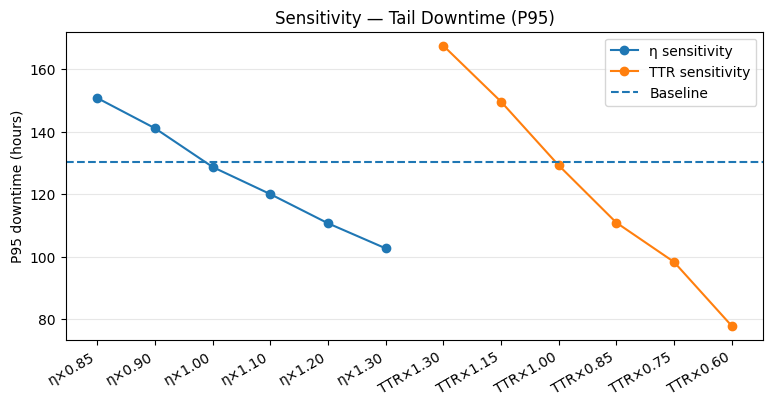

In [12]:
plt.figure(figsize=(9,4))
plt.plot(eta_sens_df["Lever"], eta_sens_df["Downtime_P95_h"], marker="o", label="η sensitivity")
plt.plot(ttr_sens_df["Lever"], ttr_sens_df["Downtime_P95_h"], marker="o", label="TTR sensitivity")
plt.axhline(base_eval["Downtime_P95_h"], linestyle="--", label="Baseline")
plt.xticks(rotation=30, ha="right")
plt.ylabel("P95 downtime (hours)")
plt.title("Sensitivity — Tail Downtime (P95)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
savefig("MC_21_4_sensitivity_downtime_p95.png")
plt.show()

### 10.3 Plot sensitivity — Risk-of-breach

Saved: figures/MC_21_4_sensitivity_risk_breach.png


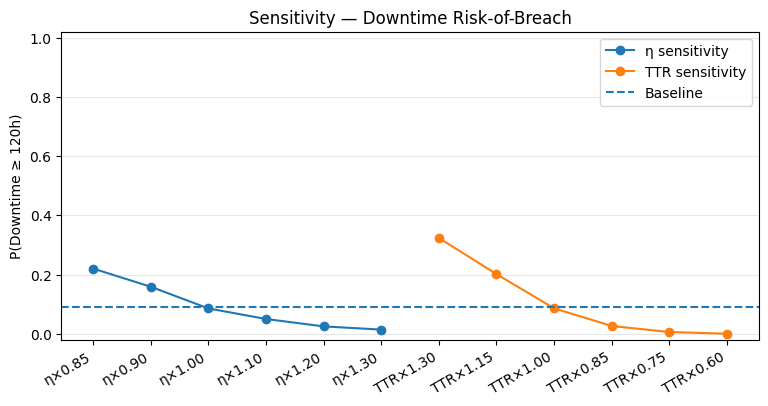

In [13]:
plt.figure(figsize=(9,4))
plt.plot(eta_sens_df["Lever"], eta_sens_df["Risk_Breach"], marker="o", label="η sensitivity")
plt.plot(ttr_sens_df["Lever"], ttr_sens_df["Risk_Breach"], marker="o", label="TTR sensitivity")
plt.axhline(base_eval["Risk_Breach"], linestyle="--", label="Baseline")
plt.xticks(rotation=30, ha="right")
plt.ylim(-0.02, 1.02)
plt.ylabel(f"P(Downtime ≥ {DOWNTIME_THRESHOLD_H:.0f}h)")
plt.title("Sensitivity — Downtime Risk-of-Breach")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
savefig("MC_21_4_sensitivity_risk_breach.png")
plt.show()

## 11) Copy-ready interpretation template

In [ ]:
best = scenario_df.sort_values(
    ["Risk_Breach_Downtime>=Threshold", "ServiceLevel_Availability>=Target"],
    ascending=[True, False]
).iloc[0]

baseline_breach = float(scenario_df.loc[scenario_df["Scenario"]=="Baseline", "Risk_Breach_Downtime>=Threshold"].values[0])

print(
f"""Copy-ready interpretation (edit as needed):

We used scenario analysis to compare reliability improvement levers using Monte Carlo simulation of a repairable fleet.
Each scenario modifies either failure frequency (η as an MTBF lever) or repair performance (TTR as a maintenance/logistics lever),
and the comparison focuses on decision KPIs: (i) risk-of-breach for downtime and (ii) service level for availability targets.

For the baseline case, the probability of exceeding {DOWNTIME_THRESHOLD_H:.0f} hours of downtime over the horizon is {baseline_breach:.1%}.
Across the evaluated options, the best-performing scenario by downtime breach risk is '{best['Scenario']}', with breach probability
{best['Risk_Breach_Downtime>=Threshold']:.1%} and availability service level {best['ServiceLevel_Availability>=Target']:.1%}
for the target {AVAILABILITY_TARGET:.4f}.

Sensitivity results show how tail downtime (P95) and breach probability respond to changes in η versus repair time (TTR),
revealing which lever dominates operational risk and should be prioritized.

Figures: MC_21_4_scenario_availability.png, MC_21_4_scenario_downtime.png, MC_21_4_scenario_decision_kpis.png,
MC_21_4_sensitivity_availability_mean.png, MC_21_4_sensitivity_downtime_p95.png, MC_21_4_sensitivity_risk_breach.png
"""
)

## 12) (Colab) Download figures/outputs (optional)

In [ ]:
# Uncomment in Colab:
# import shutil
# from google.colab import files
# shutil.make_archive("MC_21_4_figures", "zip", "figures")
# shutil.make_archive("MC_21_4_outputs", "zip", "outputs")
# files.download("MC_21_4_figures.zip")
# files.download("MC_21_4_outputs.zip")